Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## Clean Air Act Formal Enforcements by Congressional District

This notebook examines ECHO data using CASE_FACILITIES, CASE_ENFORCEMENTS and ECHO_EXPORTER.
The fields in the CASE_FACILITIES table are:
<ol>
    <li>REGISTRY_ID, </li>
    <li>CASE_NUMBER. </li>
</ol>
The fields in the CASE_ENFORCEMENTS table are:
<ol>
    <li>CASE_NUMBER, </li>
    <li>FISCAL_YEAR, </li>
    <li>CASE_STATUS_DATE, </li>
    <li>HQ_DIVISION. </li>
</ol>
The CASE_NUMBER field links these tables.

The REGISTRY_ID identifier is linked to the ECHO_EXPORTER table's field of the same name.

The HQ_DIVISION of interest for this notebook is 'CAA'.
    
A state and congressional district must be chosen using the dropdown
widgets that are provided.

In [1]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


Run this next cell, select a state, and then run the following cell.

In [2]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

In [3]:
my_state = dropdown_state.value

sql = "select REGISTRY_ID, FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, FAC_DERIVED_CD113 " + \
    " from ECHO_EXPORTER where AIR_FLAG = 'Y' and FAC_STATE = '" + my_state + "'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)


select REGISTRY_ID, FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, FAC_DERIVED_CD113  from ECHO_EXPORTER where AIR_FLAG = 'Y' and FAC_STATE = 'NY'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20REGISTRY_ID%2C%20FAC_NAME%2C%20FAC_STATE%2C%20FAC_LAT%2C%20FAC_LONG%2C%20FAC_DERIVED_CD113%20%20from%20ECHO_EXPORTER%20where%20AIR_FLAG%20%3D%20%27Y%27%20and%20FAC_STATE%20%3D%20%27NY%27


In [4]:

echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
echo_data.set_index( "REGISTRY_ID", inplace=True)

# local_data_location = "../../ICIS_Air_Violation/ECHO_EXPORTER-Air.csv"
# echo_data = pd.read_csv(local_data_location,encoding='iso-8859-1',header = 0)


Run this next cell after choosing a state from the dropdown list.

In [5]:
num_facilities = echo_data.shape[0]
print("There are %s ICIS facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 12464 ICIS facilities in NY tracked in the ECHO database.


Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.

In [6]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

Here is a map of congressional districts: https://www.govtrack.us/congress/members/map

Run this next cell after choosing a congressional district from the dropdown list.

In [7]:
my_cd = w2.value
my_cd_facs = echo_data[echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s ICIS facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 400 ICIS facilities in NY district 1 tracked in the ECHO database.


Next look up the compliance monitoring history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [8]:
# sql = "select PGM_SYS_ID, STATE_EPA_FLAG, AGENCY_TYPE_DESC, COMP_MONITOR_DESC, ACTUAL_END_DATE from `ICIS-AIR_FCES_PCES` where STATE_CODE='" + my_state + "'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='

sql = "select CF.REGISTRY_ID, CE.FISCAL_YEAR, CE.CASE_STATUS_DATE from `CASE_FACILITIES` CF, `CASE_ENFORCEMENTS` CE" + \
   " where CE.HQ_DIVISION = 'AIR' and CE.CASE_NUMBER = CF.CASE_NUMBER"
# sql = "select distinct( HQ_DIVISION ) from CASE_ENFORCEMENTS"
# sql = "show columns from `ICIS_FEC_EPA_INSPECTIONS`"
# sql = "show tables from slim_echoepa_a"
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)

select CF.REGISTRY_ID, CE.FISCAL_YEAR, CE.CASE_STATUS_DATE from `CASE_FACILITIES` CF, `CASE_ENFORCEMENTS` CE where CE.HQ_DIVISION = 'AIR' and CE.CASE_NUMBER = CF.CASE_NUMBER
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20CF.REGISTRY_ID%2C%20CE.FISCAL_YEAR%2C%20CE.CASE_STATUS_DATE%20from%20%60CASE_FACILITIES%60%20CF%2C%20%60CASE_ENFORCEMENTS%60%20CE%20where%20CE.HQ_DIVISION%20%3D%20%27AIR%27%20and%20CE.CASE_NUMBER%20%3D%20CF.CASE_NUMBER


In [9]:
icis_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
icis_data.set_index( "REGISTRY_ID", inplace=True)

In [10]:
# Find the facility that matches the inspection, by REGISTRY_ID.

my_cd_icis = pd.DataFrame()
no_data_ids = []
# Look through all facilities in my CD.
for fac in my_cd_facs.itertuples():
    # breakpoint()
    fac_id = fac.Index
    try:
        enforcements = icis_data.loc[ fac_id ].copy()
        # breakpoint()
        n = enforcements.shape[0]
        fac_list = [fac.Index] * n
        enforcements['facility'] = fac_list
        frames = [my_cd_icis, enforcements]
        my_cd_icis = pd.concat( frames, ignore_index=False )
    except KeyError:
        # The facility wasn't found in the ICIS_FEC_EPA_INSPECTIONS data.
        no_data_ids.append( fac.Index )
    
# my_cd_icis.to_csv( r'my_cd_enforcements.csv', index=True, header=True )
# with open( "no_data_ids.txt", "w" ) as output:
#     output.write( str( no_data_ids ))

Map the facilities that have had these compliance evaluations.

In [11]:

print( "Facilities without enforcements: " + str( len( no_data_ids )))
print( "Facilities with enforcements: " + str( len( my_cd_icis )))
my_cd_icis

Facilities without enforcements: 397
Facilities with enforcements: 30


,FISCAL_YEAR,CASE_STATUS_DATE,facility
REGISTRY_ID,,,
110000616726,1998,02/24/1998,1.100006e+11
110000616726,1998,02/24/1998,1.100006e+11
110000616726,1998,02/24/1998,1.100006e+11
110000616726,1998,02/24/1998,1.100006e+11
110000616726,1998,02/24/1998,1.100006e+11
110000616726,1998,02/24/1998,1.100006e+11
110000616726,1998,02/24/1998,1.100006e+11
110000616726,1998,02/24/1998,1.100006e+11
110000616726,1998,02/24/1998,1.100006e+11


In [12]:
fac_idx_list = my_cd_icis['facility'].dropna()
fac_cd_icis = my_cd_facs.loc[fac_idx_list]

In [13]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_my_area = mapper(fac_cd_icis)
map_of_facilities_in_my_area

Present another dropdown with the list of names of the facilities.  Choosing a facility will display
the violations.

In [14]:
cd_array = fac_cd_icis["FAC_NAME"].unique()
cd_array.sort()

In [15]:
w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('BROOKHAVEN NATIONAL LABORATORY', 'F & H MANUFACTURING CORP PR…

Run this next cell after choosing a facility.

In [16]:
my_fac = fac_cd_icis[fac_cd_icis["FAC_NAME"] == w3.value]
enforcements = my_cd_icis[my_cd_icis['facility'] == my_fac.iloc[[0]].index[0]]

In [17]:
# This cell creates a function that will be used by both the CD and the state
# to plot the number of cases by year.
import datetime

def show_plot( df, date_field, year_field, place, date_format, chart_title ):
    format_str = date_format # The format
    nan_count = 0
    year_col = []
    for day in df[date_field]:
        try:
            # breakpoint()
            viol_year = datetime.datetime.strptime(day, format_str).year
            year_col.append( viol_year )
        except:
            nan_count += 1
            year_col.append(  np.NaN )
    df[year_field] = year_col
    
    year_groups = df.groupby( year_field )[[ year_field ]]
    counted_years = year_groups.count()

    # Print how many values are present 
    print(counted_years)
    chart_title +=  " in " + place + " by year"

    ax = counted_years[[year_field]].plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

## Plot the number of enforcements by year for the congressional district.

                  CASE_STATUS_YEAR
CASE_STATUS_YEAR                  
1987                             2
1996                             4
1998                            24


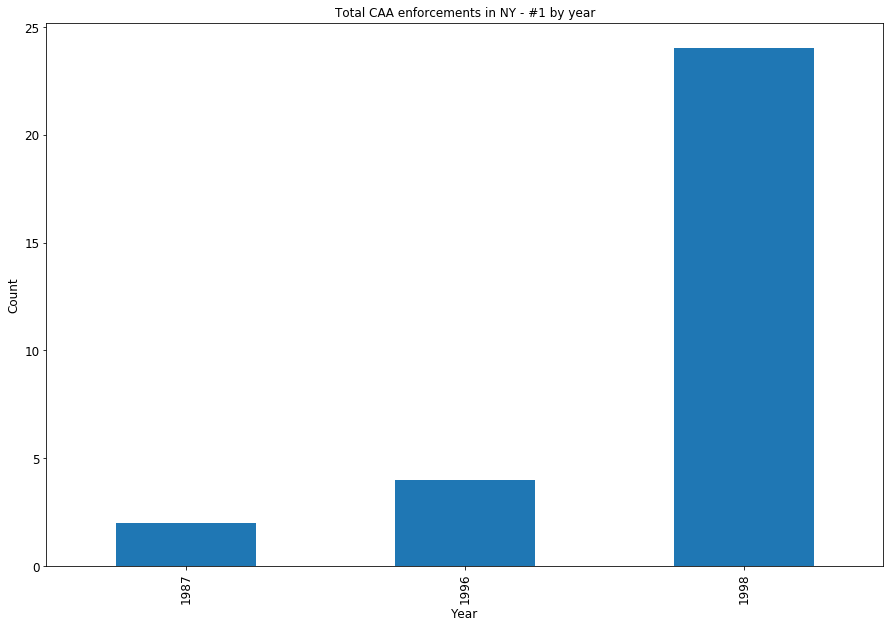

In [18]:
chart_title = "Total CAA enforcements"

show_plot( my_cd_icis, 'CASE_STATUS_DATE', 'CASE_STATUS_YEAR', \
          my_state + ' - #' + str( my_cd ), "%m/%d/%Y", chart_title )

## Plot the number of enforcements by year, using the entire state.
Since the number of enforcements in a single CD may be small, it can be more
interesting to look at the entire state.

                  CASE_STATUS_YEAR
CASE_STATUS_YEAR                  
1976                            48
1977                            44
1978                            46
1979                           101
1980                            62
1981                           188
1982                            81
1983                            95
1984                            89
1985                           105
1986                           257
1987                           336
1988                           352
1989                           365
1990                           283
1991                           238
1992                           240
1993                           321
1994                           441
1995                           505
1996                           621
1997                           760
1998                           870
1999                          1054
2000                          1008
2001                          1098
2002                

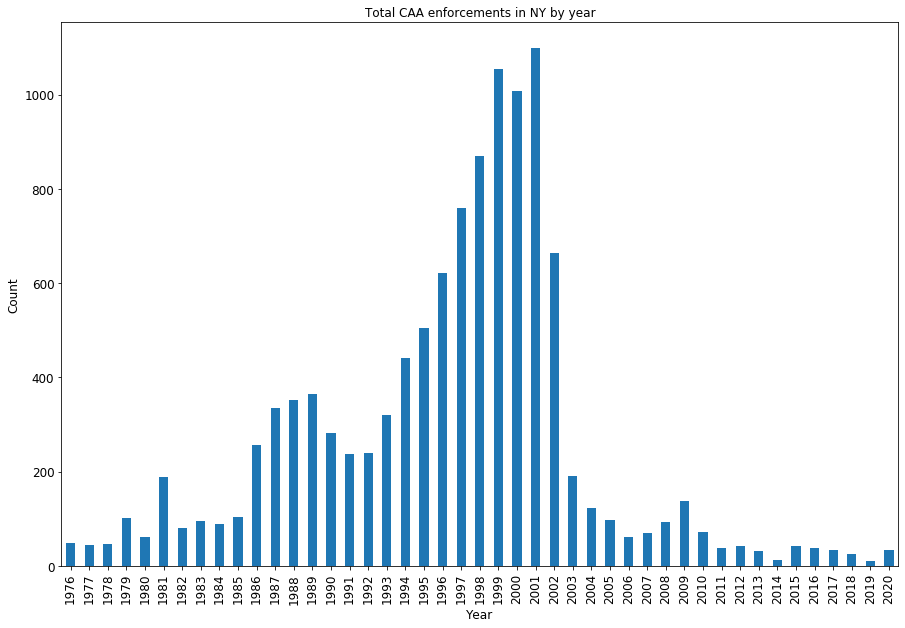

In [19]:
chart_title = "Total CAA enforcements"

show_plot( icis_data, 'CASE_STATUS_DATE', 'CASE_STATUS_YEAR', my_state, \
          "%m/%d/%Y", chart_title )